<div style="background: #DDE2FF;
            font-family: Bookerly;
            font-size: 16px; 
            font-weight: 100;
            padding: 20px 5px 0px 5px; 
            border: 10px solid #DDE2FF; 
            margin-left: 1px;
            margin-right: 1px;"
          
 <font color='blue'>**Chapter 31-2: Solving PDEs Using Differential Quadrature**. 

Differential quadrature is the approximation of derivatives by using weighted sums of function values. Differential quadrature is of practical interest because its allows one to compute derivatives from noisy data. The name is in analogy with quadrature, meaning numerical integration, where weighted sums are used in methods such as Simpson's method or the Trapezoidal rule. There are various methods for determining the weight coefficients, for example, the Savitzky–Golay filter. Differential quadrature is used to solve partial differential equations. There are further methods for computing derivatives from noisy data.
 

<br>

  </font>
  
  
  
</div>

<div style="background: #FFE3CC;
            font-family: Bookerly;
            font-size: 16px; 
            font-weight: 100;
            padding: 15px 5px 10px 5px;
            border: 10px solid #FFE3CC;  
            margin-left: 1px;
            margin-right: 1px;"
     
<font color='blue'>1.1. Solve the one-dimensional Burgers' equation,

$$\frac{\partial u}{\partial t}\,-\,\nu\frac{\partial^2 u}{\partial x^2}\,+\,u\frac{\partial u}{\partial x}\,=\,0$$

while observing a boundary condition of 

$$u(x,0)\,=\,f(x)\:\:\:\textrm{in}\:\:\:\Omega$$

and initial condition of

$$u(x,t)\,=\,0\:\:\:\textrm{on}\:\:\:\partial \Omega\:\scriptsize{\times}\:(0,T]$$


</font>
</div>

In [1]:
'''
    Numerical Solution of Burger's Equation based on Differential Quadrature method.
    Reference Paper - https://onlinelibrary.wiley.com/doi/10.1002/num.22178
    Solution taken from the Github repository of mn619.
'''



"\n    Numerical Solution of Burger's Equation based on Differential Quadrature method.\n    Reference Paper - https://onlinelibrary.wiley.com/doi/10.1002/num.22178\n"

In [2]:
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



In [3]:
N, M = 30, 30  #Mesh Size
iteration = 5 #Number of times to iterate for finding numerical solution
mu = 0.1
pi = np.pi



In [4]:
'''
    Setting up everything as global variables
'''

x = [(1-np.cos(pi*(i - 1)/(M - 1)))*0.5 for i in range(M + 1)]
t = [(1-np.cos(pi*(i - 1)/(N - 1)))*0.5 for i in range(N + 1)]

A_init = np.zeros((N + 1, N + 1))
B_init = [np.zeros((M + 1, M + 1)) for i in range(3)]
A = np.zeros((N - 1, N - 1))
B = [np.zeros((M - 2, M - 2)) for i in range(3)]
alpha = [np.zeros((N - 1, M - 2)) for i in range(iteration + 1)]
beta = np.zeros((M - 2, M - 2))
F = [np.zeros((N - 1, M - 2)) for i in range(iteration + 1)]
U_init = [np.zeros((N + 1, M + 1)) for i in range(iteration + 1)]
U = [np.zeros((N - 1, M - 2)) for i in range(iteration + 1)] 
beta_k = np.zeros(((N - 1)*(M - 2), (N - 1)*(M - 2)))



In [5]:
'''
    All the functions required to initialize the variables
'''

def f(x):
        return np.sin(np.pi*x)

def cal_coef(n, mu):
    ans = 0
    for i in range(0, 1000):
        x = (2*i + 1)/2000
        ans += math.exp(-(1-np.cos(np.pi*x))/(2*np.pi*mu))*np.cos(n*np.pi*x)*1/1000
    if(n == 0):
        return ans
    else:
        return 2*ans
    
def cal_A(n, m):
    ans = 1
    if(n != m):
        for l in range(1, M + 1):
            if(l != n and l != m):
                ans *= (x[n] - x[l])/(x[m] - x[l])
        ans *= 1/(x[m] - x[n])
    else:
        ans = 0
        for l in range(1, M + 1):
            if(l != n):
                ans += 1/(x[n] - x[l])
    return ans

def cal_B(n, m):
    ans = 1
    if(n != m):
        for l in range(1, N + 1):
            if(l != n and l != m):
                ans *= (t[n] - t[l])/(t[m] - t[l])
        ans *= 1/(t[m] - t[n])
    else:
        ans = 0
        for l in range(1, N + 1):
            if(l != m):
                ans += 1/(t[m] - t[l])
    return ans

def cal_alpha(n, m, k):
    ans = 0
    for j in range(1, M + 1):
        ans += B_init[1][m + 2,j]*U_init[k][n + 2, j]
    return ans

def cal_F(n, m, k):
    return U_init[k][n + 2, m + 2]*alpha[k][n,m] - A_init[n + 2][1]*f(x[m + 2])

def vec(X):
    assert(X.shape == (N - 1, M - 2))
    temp = X.flatten('F')
    return temp.reshape(-1, 1)

def diag(X):
    assert(len(X) == (N - 1)*(M - 2))
    return np.diagflat(X)



In [6]:
'''
    Initialising all the variables
'''
#Calculate U_init[0]
for j in range(1, M + 1):
    U_init[0][1,j] = f(x[j])

#Calculate A_init
for i in range(1, N + 1):
    for j in range(1, N + 1):
        A_init[i,j] = cal_A(i,j)
        
#Calculate B_init[1]
for i in range(1, M + 1):
    for j in range(1, M + 1):
        B_init[1][i,j] = cal_B(i,j)

#Calculate B_init[2]
for i in range(1, M + 1):
    for j in range(1, M + 1):
        if( i != j):
            B_init[2][i,j] = 2*(B_init[1][i,j]*B_init[1][i,i] - B_init[1][i,j]/(t[i] - t[j]))
    for j in range(1, N + 1):
        if(j != i):
            B_init[2][i,i] -= B_init[2][i,j]

#Calculate A
for i in range(0, N - 1):
    for j in range(0, N - 1):
        A[i,j] = A_init[i + 2,j + 2]

#Calculate B[1], B[2]
for i in range(0, M - 2):
    for j in range(0, M - 2):
        B[1][i,j] = B_init[1][i + 2,j + 2]
        B[2][i,j] = B_init[2][i + 2,j + 2]

#Calculate beta
beta = -mu*B[2]

#Calculate alpha[0]
for i in range(0, N - 1):
    for j in range(0, M - 2):
        alpha[0][i, j] = cal_alpha(i, j, 0)

#Calculate F[0]
for i in range(0, N - 1):
    for j in range(0, M - 2):
        F[0][i, j] = cal_F(i, j, 0)

#Calculate beta_k
beta_k = np.kron(beta, np.eye(N - 1))

#Calculate A_k
A_k = np.kron(np.eye(M - 2), A)

#Calculate B_k
B_k = np.kron(B[1], np.eye(N - 1))



In [7]:
'''
    This code finds the approximate numerical solution
'''
def numerical_soln():
    for k in range(1, iteration + 1):
        print("Iteration : ", k, "\r", end = "")
        D1 = np.matmul(diag(vec(U[k - 1])), B_k)
        D2 = diag(vec(alpha[k - 1]))

        mat = np.zeros(((N - 1)*(M - 2), (N - 1)*(M - 2)))

        for i in range((N - 1)*(M - 2)):
            for j in range((N - 1)*(M - 2)):
                mat[i,j] = beta_k[i,j] + A_k[i,j] + D1[i,j] + D2[i,j]
        X = np.matmul(np.linalg.inv(mat), vec(F[k-1]))
        U[k] = X.reshape((N - 1, M - 2), order = 'F')

        for i in range(1, N + 1):
            for j in range(1, M + 1):
                if(i == 1 or j == 1 or j == M):
                    U_init[k][i,j] = U_init[k - 1][i,j]
                else:
                    U_init[k][i,j] = U[k][i - 2, j - 2]
        for i in range(N - 1):
            for j in range(M - 2):
                alpha[k][i,j] = cal_alpha(i,j,k)
                F[k][i,j] = cal_F(i,j,k)
    print('\n')
    return U_init[iteration]



In [8]:
'''
    Exact solution as described in the paper
'''
def exact_soln():
    c = [cal_coef(i, mu) for i in range(0 ,100)]
    u = np.zeros((N + 1, M + 1))

    for i in range(1, N + 1):
        for j in range(1, M + 1):
            xx = x[j]
            tt = t[i]
            numerator = 0
            denominator = 0
            for n in range(1, 100):
                numerator += c[n]*math.exp(-n*n*pi*pi*mu*tt)*n*np.sin(n*pi*xx)
                denominator += c[n]*math.exp(-n*n*pi*pi*mu*tt)*np.cos(n*pi*xx)
            denominator += c[0]
            u[i][j] = 2*pi*mu*numerator/denominator
    return u



In [9]:
u = exact_soln()
u_num = numerical_soln()

print("Error : ", (u_num - u).max())



Iteration :  5 

Error :  4.612299431272504e-11


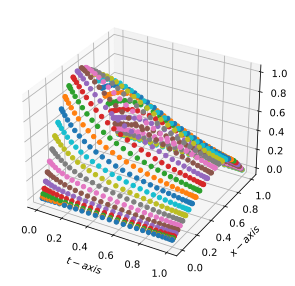

In [10]:
'''
    plotting the numerical solution obtained
'''
%config InlineBackend.figure_formats = ['svg']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(1, N + 1):
    for j in range(1, M + 1):
        ax.scatter(t[i], x[j], u_num[i,j])
        
ax.set_xlabel('$t-axis$')
ax.set_ylabel('$x-axis$')
ax.set_zlabel('u')

plt.show()



<div style="background: #FFE3CC;
            font-family: Bookerly;
            font-size: 16px; 
            font-weight: 100;
            padding: 15px 5px 10px 5px;
            border: 10px solid #FFE3CC;  
            margin-left: 1px;
            margin-right: 1px;"
     
<font color='blue'>Problem 1.2. Analyze the free vibration of a simply supported beam, using differential quadrature.

</font>
</div>

<div style="background: #E2FFCC;
            font-family: Bookerly;
            font-size: 16px; 
            font-weight: 100;
            padding: 10px 5px 10px 5px; 
            border: 10px solid #E2FFCC; 
            margin-left: 1px;
            margin-right: 1px;"

<font color='blue'>With Octave as the tool, a program authored by Professor Francesco Tornabene is presented. Further information (on shell structures, not beams) can be found in a paper by the same author, _Static analysis of doubly-curved anisotropic shells and panels using CUF approach, differential geometry and differential quadrature method_.


</font>                 
</div>

In [ ]:
% Beam Problem - Simply-supported Euler-Bernoulli Beam
clear
clc
% data
L=2;
b=0.01;
h=0.01;
A=b*h;
I=1/12*b*h^3;
E=2.1e11;
ni=0.3;
rho=7800;
q0=100;
% numerical data
N=31;
m=4;
% Weighting coefficients for derivation
r=zeros(1,N);
for k=1:N
r(k)=cos(((2*k-1)*pi)/(2*N));
end
r=sort(r);
% first derivative of Chebyshev polynomial of the first kind
dCheb_1=(N*sin(N*acos(r)))./(1 - r.^2).^(1/2);
c=zeros(N,N,m);
for p=1:m
if p==1
% first order derivative weighting coefficients
for i=1:N
for j=1:N
if i==j
else
c(i,j,p)=dCheb_1(i)/((r(i)-r(j))*dCheb_1(j));
end
end
end
else
% higher order derivative weighting coefficients
for i=1:N
for j=1:N
if i==j
else
c(i,j,p)=p*(c(i,j,1)*c(i,i,p-1)-c(i,j,p-1)*((r(i)-r(j))^(-1)));
end
end
end
end
% diagonal weighting coefficients for each order derivative
for i=1:N
c(i,i,p)=-sum(c(i,:,p));
end
end
% domain length
L1=r(N)-r(1);
% coordinate transformation
x=(r-r(1))/(r(N)-r(1))*L;
% weighting coefficients transformation
for p=1:m
c(:,:,p)=(L1/L)^p*c(:,:,p);
end
% Strong formulation
Ks=E*I*c(:,:,4);
Fs=q0*b*ones(N,1);
Ms=rho*A*eye(N);
% boundary conditions
Ks(1,1)=1;
Ks(1,2:N)=zeros(1,N-1);
Ks(2:N,1)=zeros(N-1,1);
Ks(N,N)=1;
Ks(N,1:N-1)=zeros(1,N-1);
Ks(1:N-1,N)=zeros(N-1,1);
Ks(2,:)=E*I*c(1,:,2);
Ks(N-1,:)=E*I*c(N,:,2);
% boundary conditions for loads
Fs(1)=0;
Fs(2)=0;
Fs(N-1)=0;
Fs(N)=0;
% static analysis
us=Ks\Fs;
% dynamic analysis
Kdds=Ks(3:N-2,3:N-2);
Kdbs=[Ks(3:N-2,1:2) Ks(3:N-2,N-1:N)];
Kbbs=[Ks(1:2,1:2) Ks(1:2,N-1:N); Ks(N-1:N,1:2) Ks(N-1:N,N-1:N)];
Kbds=[Ks(1:2,3:N-2); Ks(N-1:N,3:N-2)];
Mddgs=Ms(3:N-2,3:N-2);
% eigenvalue problem
Hs=sqrt(eig(Mddgs\(-Kdbs*(Kbbs\Kbds)+Kdds)));
% circular frequencies
omegas=sort(Hs);
% frequencies
freqs=real(omegas/(2*pi));
% Exact solution
u_ex=q0*b*L^4/(24*E*I)*(x.^4/L^4-2*x.^3/L^3+x/L);
% Exact solution: dynamic analysis
freq_ex=zeros(N-4,1);
for i=1:N-4
freq_ex(i,1)=(((i^2)*(pi/2))/(L^2))*sqrt((E*I)/(rho*A));
end
Freqs=freqs./freq_ex;
% static deformation
figure
plot(x,u_ex,'r-',x,us,'kd')
set(gca,'Ydir','reverse')
% dynamic frequencies comparison
figure
plot(((1:N-4)-1)/(N-5),0*(Freqs-1)*100,'r-',((1:N-4)-1)/(N-5),(Freqs-1)*100,'kd-')
ylim([-10 10])
xlim([0 1])

#add some space to allow the PDF to be printed without glaring gap






























<img src="image01.svg" />